In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
input0 = "../input/intel-data-scene/scene_classification/scene_classification"
print(os.listdir(input0))

# Any results you write to the current directory are saved as output.b

['train', 'test', 'train.csv']


In [2]:
dataset = pd.read_csv(input0+'/train.csv')

In [3]:
dataset.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [4]:
#Using Transfer Learning
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [5]:
num_classes = 6
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
model.add(Dense(num_classes, activation='softmax'))

In [6]:
# Say not to train first layer (ResNet) model. It is already trained
model.layers[0].trainable = False

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [10]:
image_size = 150
batch_size=15
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
from sklearn.model_selection import train_test_split

train, validate = train_test_split(dataset, test_size=0.20, random_state=0)
train = train.reset_index(drop=True)
train['label'] = train['label'].astype(str)
validate = validate.reset_index(drop=True)
validate['label'] = validate['label'].astype(str)

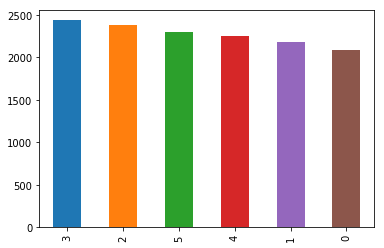

In [12]:
train['label'].value_counts().plot.bar()

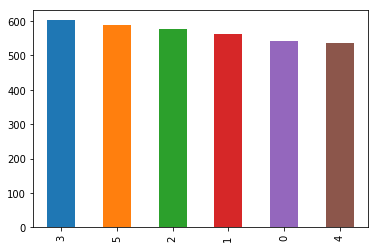

In [13]:
validate['label'].value_counts().plot.bar()

In [14]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = datagen.flow_from_dataframe(
    train, 
    input0 + "/train/", 
    x_col='image_name',
    y_col='label',
    target_size=(image_size, image_size),
    class_mode='categorical',
    batch_size=batch_size
)

Found 13627 images belonging to 6 classes.


In [15]:
validate_generator = datagen.flow_from_dataframe(
    validate, 
    input0 + "/train/", 
    x_col='image_name',
    y_col='label',
    target_size=(image_size, image_size),
    class_mode='categorical',
    batch_size=batch_size
)

Found 3407 images belonging to 6 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Found 1 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


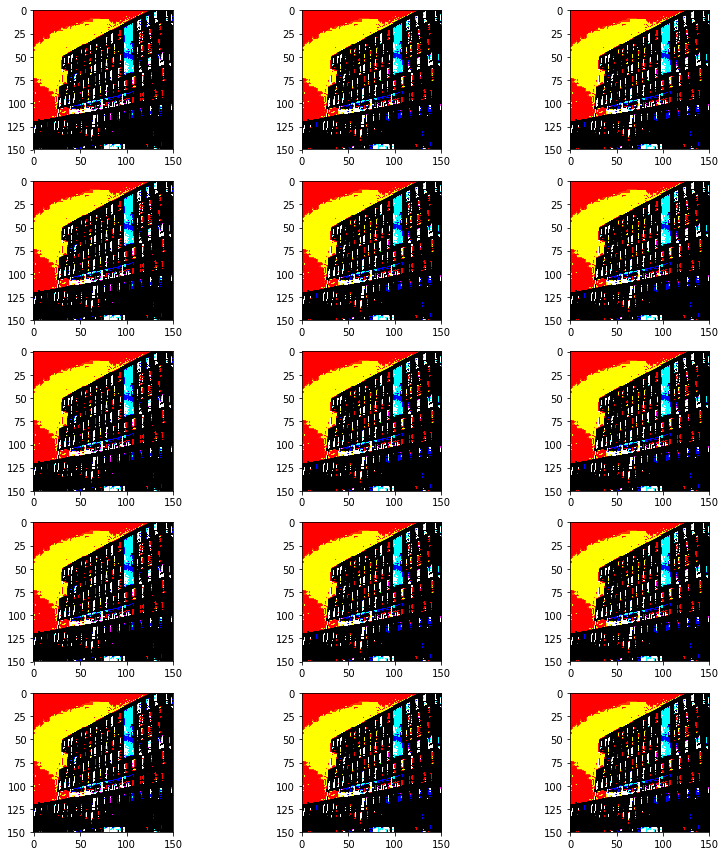

In [16]:
example = train.sample(n=1).reset_index(drop=True)
example_generator = datagen.flow_from_dataframe(
    example, 
    input0 + "/train/", 
    x_col='image_name',
    y_col='label',
    target_size=(image_size, image_size),
    class_mode='categorical',
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
model_checkpoint = ModelCheckpoint("weights.{epoch:02d}-{val_loss:.4f}.hdf5", verbose=1, period=5)
earlystop = EarlyStopping(patience=10, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
callbacks = [model_checkpoint, earlystop, learning_rate_reduction]

FAST_RUN = False
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validate_generator,
    validation_steps=validate.shape[0]//batch_size,
    steps_per_epoch=train.shape[0]//batch_size,
    callbacks=callbacks
)

Epoch 1/50
908/908 [==============================] - 69s 76ms/step - loss: 0.4229 - acc: 0.8507 - val_loss: 0.2516 - val_acc: 0.9101
Epoch 2/50
908/908 [==============================] - 54s 60ms/step - loss: 0.3154 - acc: 0.8881 - val_loss: 0.2764 - val_acc: 0.9025
Epoch 3/50
907/908 [============================>.] - ETA: 0s - loss: 0.2745 - acc: 0.9035
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
908/908 [==============================] - 54s 60ms/step - loss: 0.2744 - acc: 0.9035 - val_loss: 0.2785 - val_acc: 0.9066
Epoch 4/50
908/908 [==============================] - 53s 59ms/step - loss: 0.2261 - acc: 0.9162 - val_loss: 0.2514 - val_acc: 0.9110
Epoch 5/50
906/908 [============================>.] - ETA: 0s - loss: 0.2204 - acc: 0.9176
Epoch 00005: saving model to weights.05-0.2367.hdf5
908/908 [==============================] - 54s 59ms/step - loss: 0.2204 - acc: 0.9175 - val_loss: 0.2367 - val_acc: 0.9113
Epoch 6/50
908/908 [==================

In [18]:
model.layers[0].trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 23,546,886
Non-trainable params: 53,120
_________________________________________________________________


In [19]:
FAST_RUN = False
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validate_generator,
    validation_steps=validate.shape[0]//batch_size,
    steps_per_epoch=train.shape[0]//batch_size,
    callbacks=callbacks
)

Epoch 1/50
907/908 [============================>.] - ETA: 0s - loss: 1.9788 - acc: 0.5197
Epoch 00001: saving model to weights.01-6.8668.hdf5
908/908 [==============================] - 104s 115ms/step - loss: 1.9796 - acc: 0.5196 - val_loss: 6.8668 - val_acc: 0.3565
Epoch 2/50
908/908 [==============================] - 90s 99ms/step - loss: 1.7940 - acc: 0.5660 - val_loss: 0.8847 - val_acc: 0.6699
Epoch 3/50
908/908 [==============================] - 90s 99ms/step - loss: 1.1787 - acc: 0.6738 - val_loss: 1.2960 - val_acc: 0.6811
Epoch 4/50
908/908 [==============================] - 90s 99ms/step - loss: 0.6967 - acc: 0.7501 - val_loss: 0.6168 - val_acc: 0.7930
Epoch 5/50
908/908 [==============================] - 89s 98ms/step - loss: 0.6204 - acc: 0.7797 - val_loss: 0.6800 - val_acc: 0.7630
Epoch 6/50
907/908 [============================>.] - ETA: 0s - loss: 0.5953 - acc: 0.7892
Epoch 00006: saving model to weights.06-0.7111.hdf5

Epoch 00006: ReduceLROnPlateau reducing learning rat

In [20]:
test_files = os.listdir(input0+"/test")
test = pd.DataFrame({
    'image_name': test_files
})

In [21]:
test_generator = datagen.flow_from_dataframe(
    test, 
    input0+"/test/", 
    x_col='image_name',
    y_col=None,
    class_mode=None,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False
)

Found 7301 images.


In [22]:
predict = model.predict_generator(test_generator, steps=np.ceil(test.shape[0]/batch_size))

In [23]:
y_pred = predict.argmax(axis=-1)

In [24]:
y_pred

array([1, 0, 2, ..., 1, 0, 3])

In [25]:
test['label'] = y_pred

In [26]:
test.head(10)

,image_name,label
0,8785.jpg,1
1,10679.jpg,0
2,20675.jpg,2
3,21831.jpg,4
4,14093.jpg,5
5,7723.jpg,5
6,19341.jpg,3
7,14587.jpg,1
8,11953.jpg,3
9,6162.jpg,5


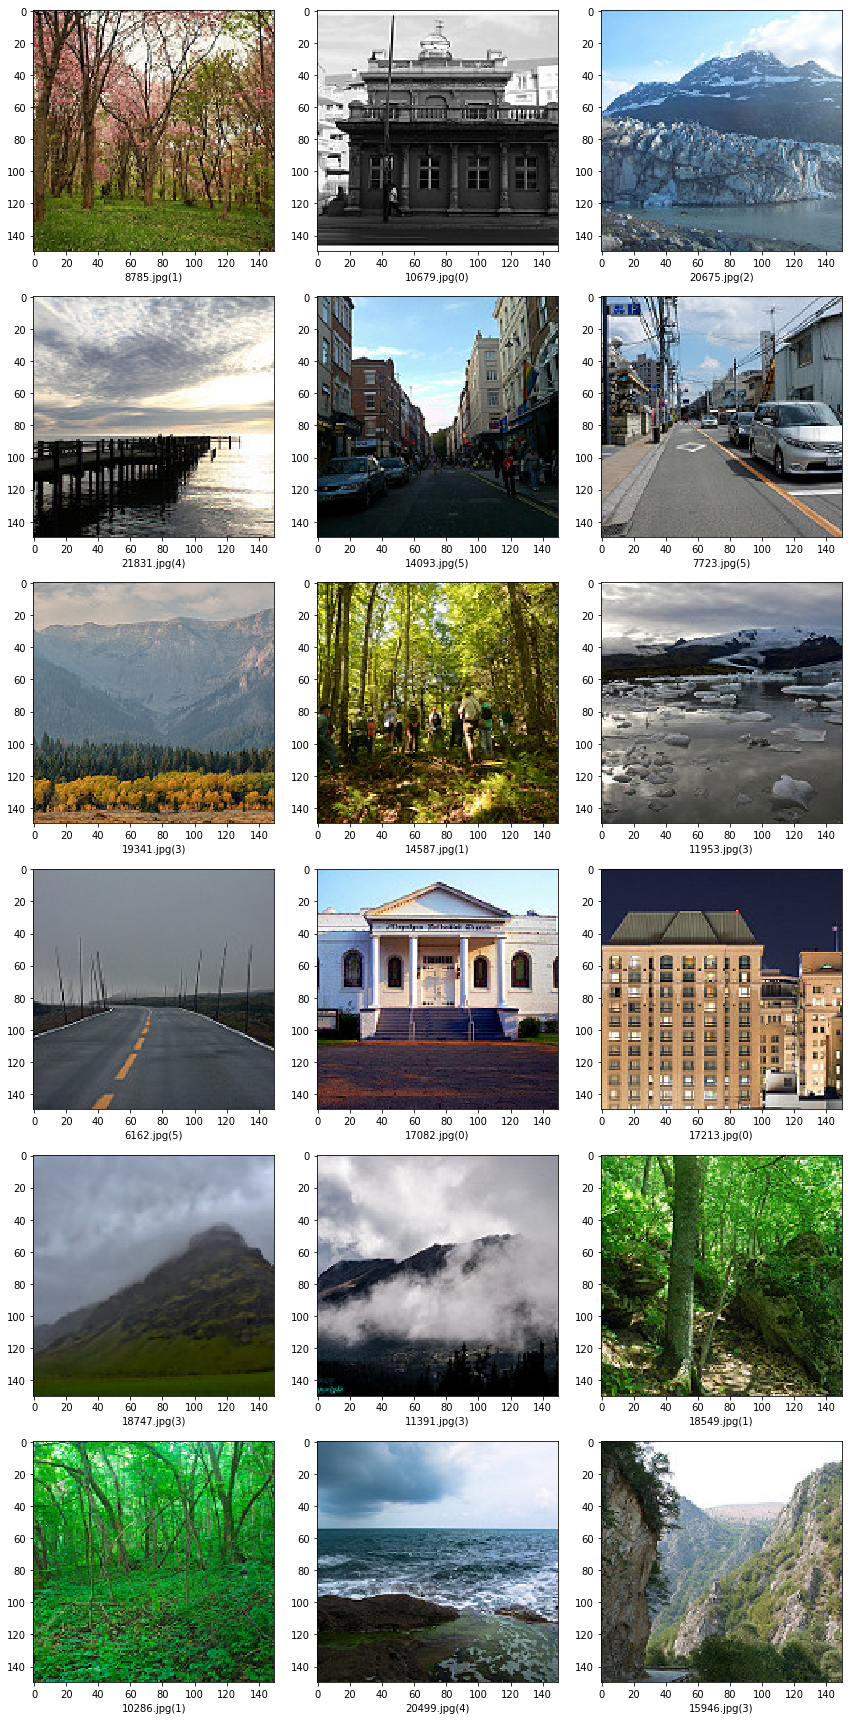

In [27]:
from tensorflow.python.keras.preprocessing.image import load_img
sample_test = test.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['image_name']
    category = row['label']
    img = load_img(input0+"/test/"+filename, target_size=(image_size, image_size))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

In [28]:
test.to_csv('submission.csv', index=False)